Downloading and Installing All the Dependencies

In [0]:
pip install pyDocumentDB

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
import pandas as pd
import time
from datetime import datetime
from datetime import timezone
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import pydocumentdb
from pydocumentdb import document_client
from pydocumentdb import documents
import datetime

Connect to Secret Scope of Databricks for secured access of storage keys

In [0]:
stgkeys = dbutils.secrets.get("storageaccountscope","devsaus-storagekeys")
storage_account_name = "youraccount"

spark.conf.set(
  "fs.azure.account.key."+storage_account_name+".dfs.core.windows.net",
  stgkeys)

Connect to file location to access file

In [0]:
file_location1 = "abfss://loc"
file_type = "csv"


Parameters for Databricks and SQL DB connection

In [0]:
#driver = "com.microsoft.sqlserver.jdbc.SQLServerDriver"

database_host = "yourserver.database.windows.net"
database_port = "1433" # update if you use a non-default port
database_name = "yourdB"
user = "youruser"
password = "yourpass"


Pull the data and create a pyspark dataframe from multiple tables from 'DB_Name'

In [0]:
cc_data1 = (spark.read
  .format("sqlserver")
  .option("host", database_host)
  .option("port", database_port) # optional, can use default port 1433 if omitted
  .option("user", user)
  .option("password", password)
  .option("database", database_name)
  .option("dbtable", "azuredemo.credit_card_data1") # (if schemaName not provided, default to "dbo")
  .load()
)

In [0]:
cc_trans_data1 = (spark.read
  .format("sqlserver")
  .option("host", database_host)
  .option("port", database_port) # optional, can use default port 1433 if omitted
  .option("user", user)
  .option("password", password)
  .option("database", database_name)
  .option("dbtable", "azuredemo.credit_card_data_transactions1") # (if schemaName not provided, default to "dbo")
  .load()
)

In [0]:
dim_cust_data1 = (spark.read
  .format("sqlserver")
  .option("host", database_host)
  .option("port", database_port) # optional, can use default port 1433 if omitted
  .option("user", user)
  .option("password", password)
  .option("database", database_name)
  .option("dbtable", "azuredemo.dim_customer1") # (if schemaName not provided, default to "dbo")
  .load()
)

In [0]:
dim_loan_data1 = (spark.read
  .format("sqlserver")
  .option("host", database_host)
  .option("port", database_port) # optional, can use default port 1433 if omitted
  .option("user", user)
  .option("password", password)
  .option("database", database_name)
  .option("dbtable", "azuredemo.dim_loan1") # (if schemaName not provided, default to "dbo")
  .load()
)

In [0]:
fact_loan_data1 = (spark.read
  .format("sqlserver")
  .option("host", database_host)
  .option("port", database_port) # optional, can use default port 1433 if omitted
  .option("user", user)
  .option("password", password)
  .option("database", database_name)
  .option("dbtable", "azuredemo.fact_loan1") # (if schemaName not provided, default to "dbo")
  .load()
)

Pull data from storage account and create a pyspark dataframe 

In [0]:

cust_scores1 = spark.read.format(file_type).option("header", "true").load(file_location1)

Configuring setting and connection with CosmosDB

In [0]:
config = {
  "spark.cosmos.accountEndpoint": "https://cosmosendpoint",
  "spark.cosmos.accountKey": "key",
  "spark.cosmos.database": "db001",
  "spark.cosmos.container": "custprofile"
}

In [0]:
spark.conf.set("spark.sql.catalog.cosmosCatalog", "com.azure.cosmos.spark.CosmosCatalog")
spark.conf.set("spark.sql.catalog.cosmosCatalog.spark.cosmos.accountEndpoint", config["spark.cosmos.accountEndpoint"])
spark.conf.set("spark.sql.catalog.cosmosCatalog.spark.cosmos.accountKey", config["spark.cosmos.accountKey"])

Converting pyspark dataframe to Pandas dataframe for executing ML code

In [0]:
dim_cust_data = dim_cust_data1.toPandas()
dim_loan_data = dim_loan_data1.toPandas()
cc_data = cc_data1.toPandas()
fact_loan_data = fact_loan_data1.toPandas()
cc_trans_data = cc_trans_data1.toPandas()
cust_scores = cust_scores1.toPandas()

Checking the dataframe content

In [0]:
dim_cust_data.head()

,id,firstname,lastname,email,gender,city,state,phone,pin
0,10001,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439
1,10002,Verna,Paucek,Verna27@yahoo.com,female,Kayceechester,Delaware,+1 (712) 116-2207,984
2,10003,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924
3,10004,Morris,McGlynn,Morris_McGlynn89@gmail.com,male,Dibbertborough,Alaska,+1 (436) 438-1272,2384
4,10005,Wilma,Carter,Wilma50@hotmail.com,female,Joanyberg,Idaho,+1 (168) 271-7969,7541


In [0]:
dim_loan_data.head()

,loan_type,rate,product
0,1,11.5,Secured
1,2,14.81,Unsecured
2,3,13.9,Consumer Goods
3,4,11,Gold
4,5,15,Personal


In [0]:
cc_data.head()

,id,cc_number,cvv,cc_accountnumber,date_of_issue,limit
0,10001,6709-7200-0000-0000,901,78943001,2023-01-04T11:56:07+01:00,100000
1,10002,6759-3800-0000-0000,696,78943002,2023-02-07T08:31:24+01:00,150000
2,10003,5018-6700-0000-0000,296,78943003,2023-01-13T19:16:02+01:00,250000
3,10004,5458-3146-7492-9964,258,78943004,2023-05-04T23:11:25+02:00,300000
4,10005,4089-1258-1779-5975,457,78943005,2023-01-21T23:26:41+01:00,60000


In [0]:
cc_trans_data.head()

,cc_number,cvv,cc_accountnumber,transaction_date,transaction_amount
0,6709-7200-0000-0000,901,78943001,5/1/2023,10000
1,6709-7200-0000-0000,901,78943001,10/3/2023,12000
2,6709-7200-0000-0000,901,78943001,11/22/2023,6000
3,6759-3800-0000-0000,696,78943002,2/15/2023,19000
4,6759-3800-0000-0000,696,78943002,3/1/2023,23000


In [0]:
fact_loan_data.head()

,id,loan_type,principal_amount,lan,date_of_loan,duration,payable_amount
0,10001,1,50000,88478908,2023-06-14T03:16:52+02:00,1,68000
1,10002,2,55000,85518292,2024-01-18T13:10:43+01:00,1,73000
2,10003,1,60000,54720840,2023-09-23T12:57:06+02:00,1,78000
3,10004,1,13000,25193224,2023-11-13T10:38:15+01:00,0.3,31000
4,10005,4,20000,35946485,2023-05-17T12:15:57+02:00,0.3,38000


Convert datatypes and create function to handle dates

In [0]:
cc_trans_data[['transaction_amount']] = cc_trans_data[['transaction_amount']].apply(pd.to_numeric)

In [0]:
from datetime import date, datetime, time
def time_convert(Date_Issue):
    stripped_time = datetime.fromisoformat(Date_Issue).astimezone(timezone.utc).strftime('%Y-%m-%d')
    return stripped_time


Starting data transformation

In [0]:
cc_data['date_of_issue'] = cc_data['date_of_issue'].apply(time_convert)
fact_loan_data['date_of_loan'] = fact_loan_data['date_of_loan'].apply(time_convert)

dim_loan_data.rename(columns={'Loan Type':'Loan_Type'},inplace=True)

loan_df = pd.merge(dim_loan_data,fact_loan_data, on='loan_type')
cust_loan_df = pd.merge(loan_df,dim_cust_data,on='id')
cc_df = pd.merge(cc_trans_data,cc_data,on='cc_number',how='outer')


In [0]:
#cc_df.head()
cc_df = cc_df.drop(['cvv_x','cc_accountnumber_x'],axis=1)

In [0]:
cc_df.head()

,cc_number,transaction_date,transaction_amount,id,cvv_y,cc_accountnumber_y,date_of_issue,limit
0,6709-7200-0000-0000,5/1/2023,10000.0,10001,901,78943001,2023-01-04,100000
1,6709-7200-0000-0000,10/3/2023,12000.0,10001,901,78943001,2023-01-04,100000
2,6709-7200-0000-0000,11/22/2023,6000.0,10001,901,78943001,2023-01-04,100000
3,6759-3800-0000-0000,2/15/2023,19000.0,10002,696,78943002,2023-02-07,150000
4,6759-3800-0000-0000,3/1/2023,23000.0,10002,696,78943002,2023-02-07,150000


In [0]:
cc_1 = cc_df.filter(['id','transaction_amount','limit','transaction_date'],axis=1)
cc_1.head()

,id,transaction_amount,limit,transaction_date
0,10001,10000.0,100000,5/1/2023
1,10001,12000.0,100000,10/3/2023
2,10001,6000.0,100000,11/22/2023
3,10002,19000.0,150000,2/15/2023
4,10002,23000.0,150000,3/1/2023


In [0]:
cc_2= cc_1.groupby('id')['transaction_amount'].sum()
cc_2.head()

id
10001    28000.0
10002    45500.0
10003    74000.0
10004    22000.0
10005    23000.0
Name: transaction_amount, dtype: float64

In [0]:
cc_3 = cc_1.groupby('id')['transaction_date'].count()
cc_4 = pd.merge(cc_2,cc_3,on='id')
cc_feature_prep = pd.merge(cc_4,cc_data,on='id')

In [0]:
cc_feature_prep.head()

,id,transaction_amount,transaction_date,cc_number,cvv,cc_accountnumber,date_of_issue,limit
0,10001,28000.0,3,6709-7200-0000-0000,901,78943001,2023-01-04,100000
1,10002,45500.0,3,6759-3800-0000-0000,696,78943002,2023-02-07,150000
2,10003,74000.0,5,5018-6700-0000-0000,296,78943003,2023-01-13,250000
3,10004,22000.0,1,5458-3146-7492-9964,258,78943004,2023-05-04,300000
4,10005,23000.0,3,4089-1258-1779-5975,457,78943005,2023-01-21,60000


In [0]:
cc_feature_prep.rename(columns = {'transaction_date':'trans_count','transaction_amount':'total_trans_amt'},inplace=True)
cc_feature_prep.head()
cc_feature_copy = cc_feature_prep.copy()

cc_feature_prep = cc_feature_prep.filter(['id','total_trans_amt','limit','trans_count'],axis=1)

In [0]:
cc_feature_prep.head()

,id
0,10001
1,10002
2,10003
3,10004
4,10005


In [0]:
cust_loan_df.head()

,loan_type,rate,product,id,principal_amount,lan,date_of_loan,duration,payable_amount,firstname,lastname,email,gender,city,state,phone,pin
0,1,11.5,Secured,10001,50000,88478908,2023-06-14,1,68000,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439
1,5,15,Personal,10001,75000,16294220,2023-02-21,0.3,93000,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439
2,1,11.5,Secured,10003,60000,54720840,2023-09-23,1,78000,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924
3,3,13.9,Consumer Goods,10003,20000,89461735,2023-11-13,0.3,38000,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924
4,1,11.5,Secured,10004,13000,25193224,2023-11-13,0.3,31000,Morris,McGlynn,Morris_McGlynn89@gmail.com,male,Dibbertborough,Alaska,+1 (436) 438-1272,2384


In [0]:
cl_f1 = cust_loan_df.filter(['id','principal_amount','date_of_loan','payable_amount'],axis=1)
cl_f1.info()

cl_f2 = cl_f1.filter(['id','principal_amount','payable_amount'],axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                200 non-null    object
 1   principal_amount  200 non-null    object
 2   date_of_loan      200 non-null    object
 3   payable_amount    200 non-null    object
dtypes: object(4)
memory usage: 7.8+ KB


In [0]:
cl_f2.head()
cl_f2[["principal_amount", "payable_amount"]] = cl_f2[["principal_amount", "payable_amount"]].apply(pd.to_numeric)

In [0]:
cl_f2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                200 non-null    object
 1   principal_amount  200 non-null    int64 
 2   payable_amount    200 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.2+ KB


In [0]:
cl_agg1 = cl_f2.groupby('id')[['principal_amount','payable_amount']].sum()

In [0]:
cl_agg1.head()

,principal_amount,payable_amount
id,,
10001,125000,161000
10002,73000,109000
10003,80000,116000
10004,233000,269000
10005,38000,74000


In [0]:
cl_f3 = cl_f1.filter(["id","date_of_loan"],axis=1)
cl_agg2 = cl_f3.groupby('id')['date_of_loan'].count()

cl_final = pd.merge(cl_agg1,cl_agg2,on='id')

test = pd.merge(cc_feature_prep,cl_final,on='id',how='outer')
combined_df = pd.merge(cust_scores,test,on='id')
feature_df = combined_df.fillna(0)

Finding correlation between data points

<AxesSubplot:>

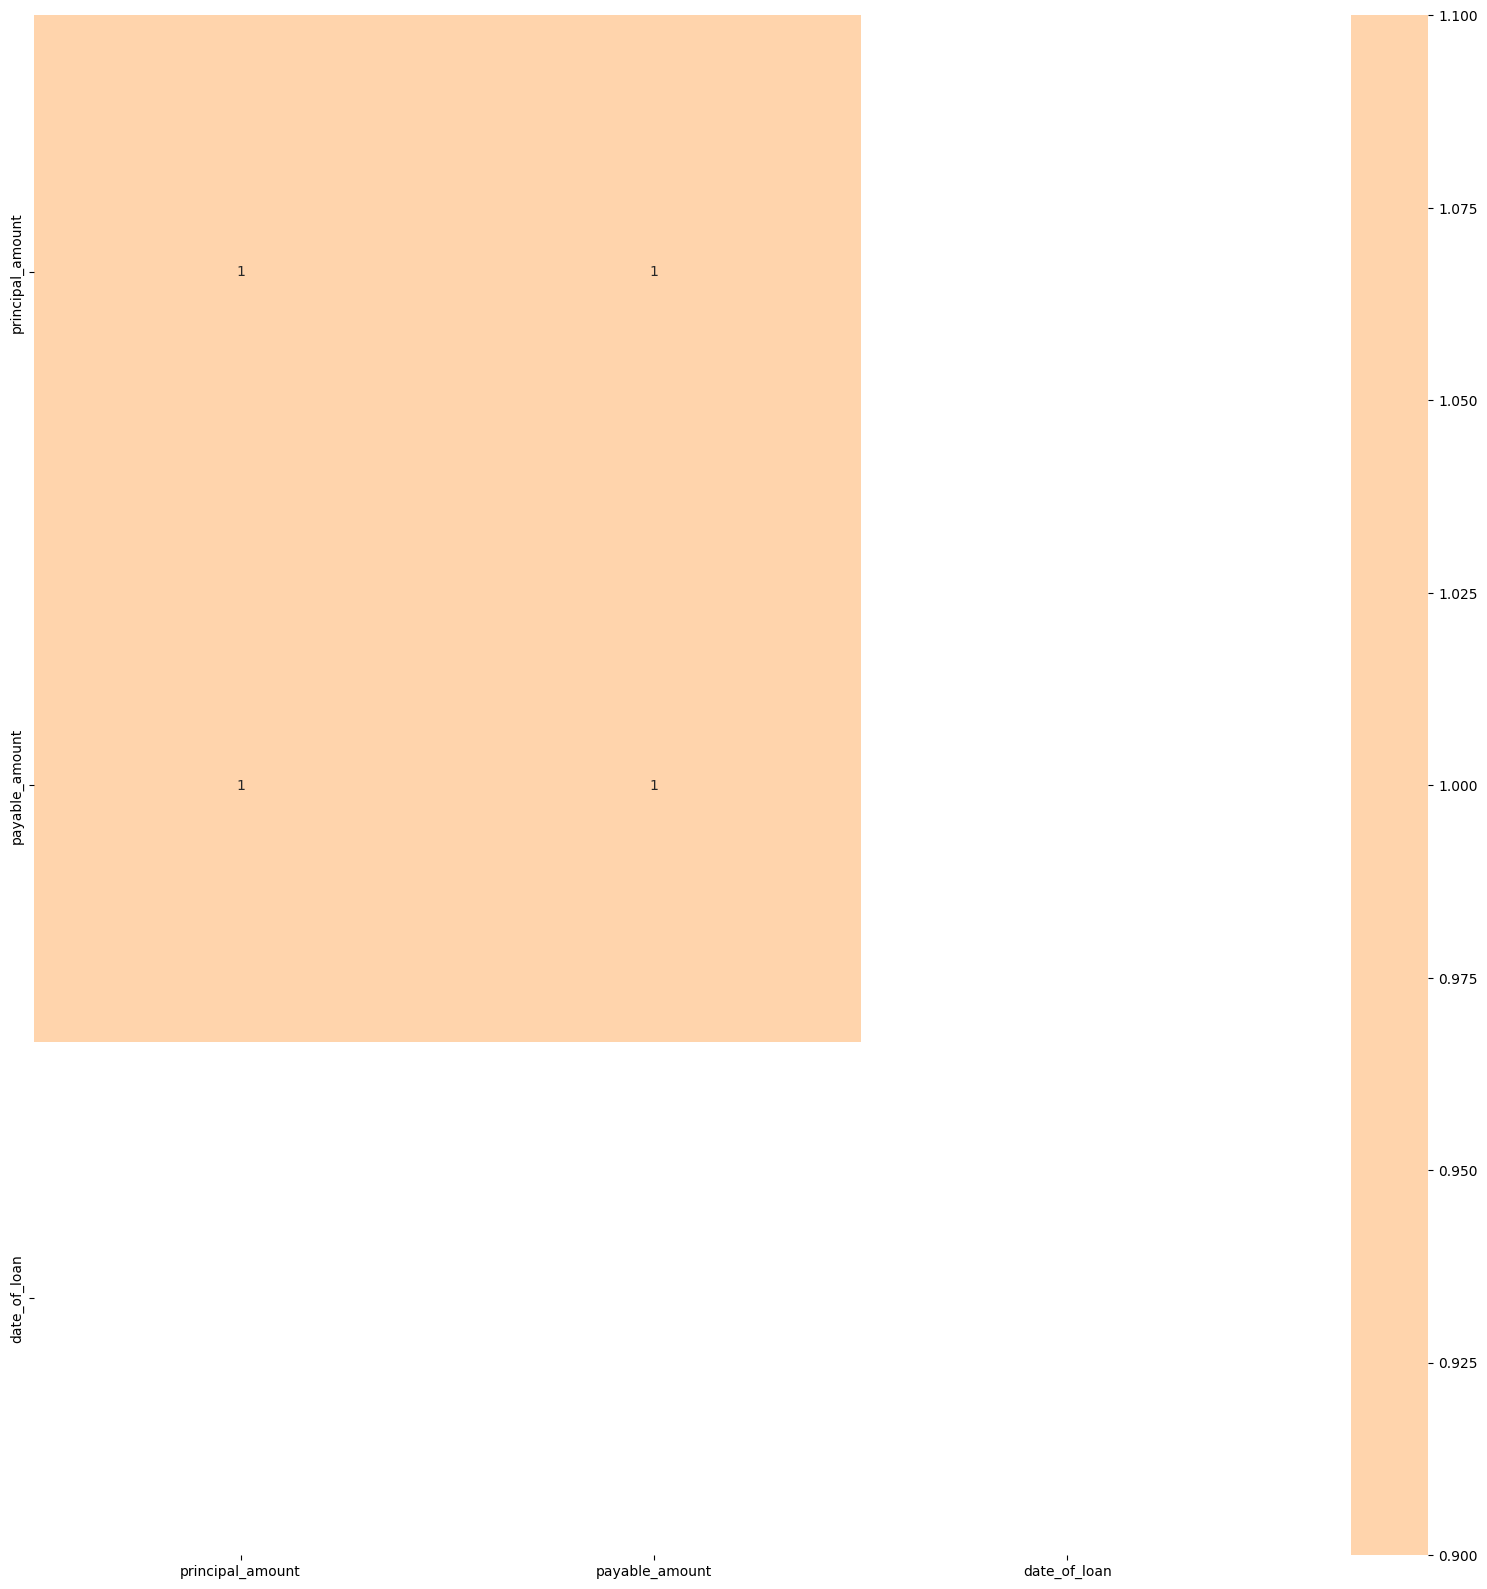

In [0]:
corr_mat = feature_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat,annot=True,center=0)

In [0]:
copy_df = feature_df.copy()
copy_df.drop(['id'],axis=1)

,score,30_day_delinq,60_day_delinq,90_day_delinq,principal_amount,payable_amount,date_of_loan
0,790,0,0,0,125000,161000,2
1,805,0,0,0,73000,109000,2
2,811,0,0,0,80000,116000,2
3,820,0,0,0,233000,269000,2
4,765,0,0,0,38000,74000,2
...,...,...,...,...,...,...,...
95,709,0,0,0,29000,65000,2
96,771,0,0,0,112000,148000,2
97,770,0,0,0,143000,179000,2
98,729,1,0,0,121000,157000,2


Scaling data before feeding to the model

In [0]:
scaler=StandardScaler()
scaler.fit(copy_df)
scaled_ds = pd.DataFrame(scaler.transform(copy_df))
print("All features are now scaled")

All features are now scaled


Running the model

In [0]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(scaled_ds)
scaled_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
feature_df["Clusters"]= yhat_AC

In [0]:
feature_df.head(50)

,id,score,30_day_delinq,60_day_delinq,90_day_delinq,principal_amount,payable_amount,date_of_loan,Clusters
0,10001,790,0,0,0,125000,161000,2,0
1,10002,805,0,0,0,73000,109000,2,0
2,10003,811,0,0,0,80000,116000,2,0
3,10004,820,0,0,0,233000,269000,2,2
4,10005,765,0,0,0,38000,74000,2,0
5,10006,710,1,1,1,129000,165000,2,3
6,10007,750,0,0,0,138000,174000,2,0
7,10008,801,0,0,0,430000,466000,2,2
8,10009,770,0,0,0,280000,316000,2,2
9,10010,788,0,0,0,105000,141000,2,0


View the clusters created by Kmeans

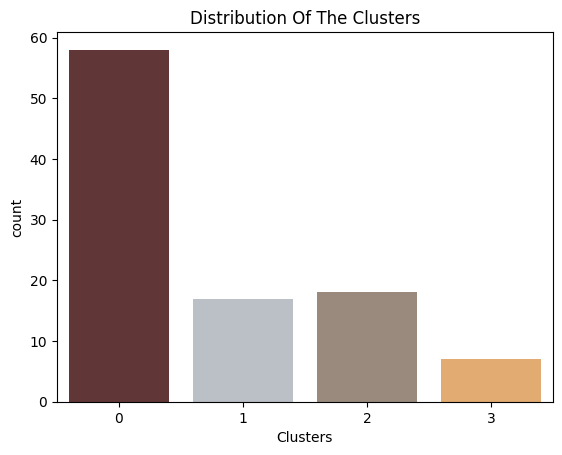

In [0]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=feature_df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [0]:
 cc_test = pd.merge(cc_4,cc_data,on='id')
 interm_df1 = pd.merge( dim_cust_data,cc_test,on='id',how='outer')
 interm_df2 = pd.merge(interm_df1,feature_df,on='id')

Re-formatting data as per businness requirement

In [0]:
result = {}
for id in fact_loan_data['id']:
    result[id] = fact_loan_data[fact_loan_data['id'] == id]['lan'].tolist()


In [0]:
acc_df = pd.DataFrame.from_dict(result)
acc_df1 = acc_df.transpose()

In [0]:
acc_df1['id'] = acc_df1.index

In [0]:
interm_df3 = pd.merge(interm_df2,acc_df1,on='id')

,id,firstname,lastname,email,gender,city,state,phone,pin,transaction_amount,transaction_date,cc_number,cvv,cc_accountnumber,date_of_issue,limit,score,30_day_delinq,60_day_delinq,90_day_delinq,principal_amount,payable_amount,Number_of_Loan,Cust_Profile,LAN1,LAN2
0,10001,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439,28000.0,3.0,6709-7200-0000-0000,901,78943001,2023-01-04,100000,790,0,0,0,125000,161000,2,0,88478908,16294220
1,10002,Verna,Paucek,Verna27@yahoo.com,female,Kayceechester,Delaware,+1 (712) 116-2207,984,45500.0,3.0,6759-3800-0000-0000,696,78943002,2023-02-07,150000,805,0,0,0,73000,109000,2,0,85518292,26035286
2,10003,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924,74000.0,5.0,5018-6700-0000-0000,296,78943003,2023-01-13,250000,811,0,0,0,80000,116000,2,0,54720840,89461735
3,10004,Morris,McGlynn,Morris_McGlynn89@gmail.com,male,Dibbertborough,Alaska,+1 (436) 438-1272,2384,22000.0,1.0,5458-3146-7492-9964,258,78943004,2023-05-04,300000,820,0,0,0,233000,269000,2,2,25193224,64313379
4,10005,Wilma,Carter,Wilma50@hotmail.com,female,Joanyberg,Idaho,+1 (168) 271-7969,7541,23000.0,3.0,4089-1258-1779-5975,457,78943005,2023-01-21,60000,765,0,0,0,38000,74000,2,0,35946485,36456303


In [0]:
interm_df3.rename(columns = {'transaction_amount':'total_cc_transactions','date_of_loan':'Number_of_Loan','Clusters':'Cust_Profile',0:'LAN1',1:'LAN2'},inplace=True)
interm_df3.head()


,id,firstname,lastname,email,gender,city,state,phone,pin,total_cc_transactions,transaction_date,cc_number,cvv,cc_accountnumber,date_of_issue,limit,score,30_day_delinq,60_day_delinq,90_day_delinq,principal_amount,payable_amount,Number_of_Loan,Cust_Profile,LAN1,LAN2
0,10001,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439,28000.0,3.0,6709-7200-0000-0000,901,78943001,2023-01-04,100000,790,0,0,0,125000,161000,2,0,88478908,16294220
1,10002,Verna,Paucek,Verna27@yahoo.com,female,Kayceechester,Delaware,+1 (712) 116-2207,984,45500.0,3.0,6759-3800-0000-0000,696,78943002,2023-02-07,150000,805,0,0,0,73000,109000,2,0,85518292,26035286
2,10003,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924,74000.0,5.0,5018-6700-0000-0000,296,78943003,2023-01-13,250000,811,0,0,0,80000,116000,2,0,54720840,89461735
3,10004,Morris,McGlynn,Morris_McGlynn89@gmail.com,male,Dibbertborough,Alaska,+1 (436) 438-1272,2384,22000.0,1.0,5458-3146-7492-9964,258,78943004,2023-05-04,300000,820,0,0,0,233000,269000,2,2,25193224,64313379
4,10005,Wilma,Carter,Wilma50@hotmail.com,female,Joanyberg,Idaho,+1 (168) 271-7969,7541,23000.0,3.0,4089-1258-1779-5975,457,78943005,2023-01-21,60000,765,0,0,0,38000,74000,2,0,35946485,36456303


Final dataframe ready for ingestion to COSMOS DB

In [0]:
final= interm_df3.drop(['transaction_date','cvv','cc_accountnumber','30_day_delinq','60_day_delinq','90_day_delinq'],axis=1)

In [0]:
final.head()

,id,firstname,lastname,email,gender,city,state,phone,pin,total_cc_transactions,cc_number,date_of_issue,limit,score,principal_amount,payable_amount,Number_of_Loan,Cust_Profile,LAN1,LAN2
0,10001,Orlando,Flatley-Veum,Orlando_Flatley-Veum@gmail.com,male,Murphyboro,South Carolina,+1 (217) 198-0340,3439,28000.0,6709-7200-0000-0000,2023-01-04,100000,790,125000,161000,2,0,88478908,16294220
1,10002,Verna,Paucek,Verna27@yahoo.com,female,Kayceechester,Delaware,+1 (712) 116-2207,984,45500.0,6759-3800-0000-0000,2023-02-07,150000,805,73000,109000,2,0,85518292,26035286
2,10003,Cynthia,Nolan,Cynthia12@gmail.com,female,Moreno Valley,Texas,+1 (311) 961-7236,3924,74000.0,5018-6700-0000-0000,2023-01-13,250000,811,80000,116000,2,0,54720840,89461735
3,10004,Morris,McGlynn,Morris_McGlynn89@gmail.com,male,Dibbertborough,Alaska,+1 (436) 438-1272,2384,22000.0,5458-3146-7492-9964,2023-05-04,300000,820,233000,269000,2,2,25193224,64313379
4,10005,Wilma,Carter,Wilma50@hotmail.com,female,Joanyberg,Idaho,+1 (168) 271-7969,7541,23000.0,4089-1258-1779-5975,2023-01-21,60000,765,38000,74000,2,0,35946485,36456303


Reconvert the Pandas Dataframe to Pyspark Dataframe and ingest to COSMOSDB container

In [0]:
cosmosdf = spark.createDataFrame(final)\
  .write \
  .format("cosmos.oltp") \
  .options(**config) \
  .mode("APPEND") \
  .save()
